In [16]:
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch

In [17]:
df = pd.read_csv('/kaggle/input/luna16-2dslices/nodule_metadata.csv')
df.head()

,seriesuid,ann_idx,z,y,x,filename,label
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,0,266,328,173,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,1
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,1,252,293,220,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,1
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2,230,251,379,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,1
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,3,142,336,377,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,1
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028...,0,76,289,354,1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028...,1


In [18]:
## we filter thoe that are not nodules

df = df[df['label'] == 1]
df['label'].value_counts()

label
1    606
Name: count, dtype: int64

In [19]:
len(set(df['seriesuid'])), len(df['seriesuid'])

(311, 606)

In [20]:
class LunaDataset(Dataset):
    
    def __init__(self, dataframe, data_path, transforms=None):
        self.df = dataframe
        self.data_path = data_path
        self.transforms = transforms

        self.X = []
        self.y = []
        self.__load_dataset()

    def __load_file_images(self, filename):
        blob = np.load(filename)
        img = blob['arr_0']
        img = np.stack([img, img, img])
        self.X.append(img)

    
    def __load_dataset(self):
        self.df['filename'].apply(lambda f: self.__load_file_images(os.path.join(self.data_path, f)))
        cx = self.df['x']
        cy = self.df['y']

        self.X = np.array(self.X)
        self.y = np.stack([cx, cy], axis=-1)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, i):

        img, label = self.X[i], self.y[i]

        img = torch.tensor(img)

        min_v = img.min()
        max_v = img.max()

        img = (img - min_v)/(max_v - min_v)
        
        if self.transforms:
            img = img.unsqueeze(0)
            img = self.transforms(img)
            img = img.squeeze(0)
        
        label = torch.tensor(label)
        label = label / 512 * 224
        
        return img, label

In [21]:
patients = list(set(df['seriesuid']))
l = len(patients)
t = int(0.8*l)
train_patients = patients[:t]
val_patients = patients[t:]

In [22]:
len(train_patients), len(val_patients), len(train_patients) + len(val_patients)

(248, 63, 311)

In [23]:
train_df = df[df['seriesuid'].isin(train_patients)]
val_df = df[df['seriesuid'].isin(val_patients)]

In [24]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = LunaDataset(train_df, '/kaggle/input/luna16-2dslices/dataset', transform)
val_dataset = LunaDataset(val_df, '/kaggle/input/luna16-2dslices/dataset', transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [25]:
img, label = train_dataset[0]
img.shape, label

(torch.Size([3, 224, 224]), tensor([ 75.6875, 143.5000]))

In [26]:
from torchvision import models
import torch.nn as nn

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 🔧 Load torchvision ViT
model = models.vit_b_16(pretrained=True)
# model = models.resnet50(pretrained=True)
model.heads.head = nn.Sequential(
    nn.Linear(model.heads.head.in_features, 128),
    nn.ReLU(),
    nn.Linear(128, 2)
)  # Output: x, y coordinates
model.to(DEVICE)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [27]:
from tqdm import tqdm

EPOCHS = 100
LR = 1e-3

criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Training"):
        images = images.to(DEVICE)
        labels = labels.float().to(DEVICE)  # shape: (B, 2)

        images = images.unsqueeze(1) if images.ndim == 3 else images

        optimizer.zero_grad()
        outputs = model(images)  # shape: (B, 2)
        # print(outputs, labels)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

    avg_train_loss = total_loss / len(train_loader.dataset)
    print(f"Train Loss: {avg_train_loss:.4f}")

    # 📉 Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Validation"):
            images = images.to(DEVICE)
            labels = labels.float().to(DEVICE)

            images = images.unsqueeze(1) if images.ndim == 3 else images
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)

    scheduler.step(avg_val_loss)
    print(f"Val Loss: {avg_val_loss:.4f}")


Epoch 1/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.28it/s]


Train Loss: 68.2989


Epoch 1/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.98it/s]


Val Loss: 41.2038


Epoch 2/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.24it/s]


Train Loss: 37.4567


Epoch 2/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.72it/s]


Val Loss: 39.1982


Epoch 3/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.27it/s]


Train Loss: 37.0897


Epoch 3/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.81it/s]


Val Loss: 39.0697


Epoch 4/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.20it/s]


Train Loss: 37.2526


Epoch 4/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.34it/s]


Val Loss: 38.7696


Epoch 5/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.28it/s]


Train Loss: 36.9208


Epoch 5/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.97it/s]


Val Loss: 39.8232


Epoch 6/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.23it/s]


Train Loss: 37.2062


Epoch 6/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.02it/s]


Val Loss: 38.8896


Epoch 7/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.27it/s]


Train Loss: 37.1986


Epoch 7/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.89it/s]


Val Loss: 39.2376


Epoch 8/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.20it/s]


Train Loss: 37.2060


Epoch 8/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.84it/s]


Val Loss: 39.2290


Epoch 9/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.25it/s]


Train Loss: 37.1921


Epoch 9/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.62it/s]


Val Loss: 39.6170


Epoch 10/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.19it/s]


Train Loss: 37.3005


Epoch 10/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.02it/s]


Val Loss: 39.9827


Epoch 11/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.29it/s]


Train Loss: 36.9260


Epoch 11/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.66it/s]


Val Loss: 39.3461


Epoch 12/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.15it/s]


Train Loss: 36.8172


Epoch 12/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.76it/s]


Val Loss: 39.1710


Epoch 13/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.28it/s]


Train Loss: 36.8217


Epoch 13/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.80it/s]


Val Loss: 39.2194


Epoch 14/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.25it/s]


Train Loss: 36.8198


Epoch 14/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.14it/s]


Val Loss: 39.1593


Epoch 15/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.28it/s]


Train Loss: 36.7852


Epoch 15/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.54it/s]


Val Loss: 39.1751


Epoch 16/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.30it/s]


Train Loss: 36.7953


Epoch 16/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.52it/s]


Val Loss: 39.0697


Epoch 17/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.23it/s]


Train Loss: 36.7654


Epoch 17/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.47it/s]


Val Loss: 39.0775


Epoch 18/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.28it/s]


Train Loss: 36.7644


Epoch 18/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.01it/s]


Val Loss: 39.0829


Epoch 19/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.27it/s]


Train Loss: 36.7668


Epoch 19/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.20it/s]


Val Loss: 39.0909


Epoch 20/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.25it/s]


Train Loss: 36.7651


Epoch 20/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.73it/s]


Val Loss: 39.0923


Epoch 21/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.27it/s]


Train Loss: 36.7657


Epoch 21/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.08it/s]


Val Loss: 39.0972


Epoch 22/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.19it/s]


Train Loss: 36.7660


Epoch 22/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.00it/s]


Val Loss: 39.1019


Epoch 23/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.26it/s]


Train Loss: 36.7615


Epoch 23/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.21it/s]


Val Loss: 39.1006


Epoch 24/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.23it/s]


Train Loss: 36.7616


Epoch 24/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 13.45it/s]


Val Loss: 39.1005


Epoch 25/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.25it/s]


Train Loss: 36.7616


Epoch 25/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.97it/s]


Val Loss: 39.1022


Epoch 26/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.30it/s]


Train Loss: 36.7620


Epoch 26/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.61it/s]


Val Loss: 39.1021


Epoch 27/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.21it/s]


Train Loss: 36.7615


Epoch 27/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.16it/s]


Val Loss: 39.1018


Epoch 28/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.19it/s]


Train Loss: 36.7617


Epoch 28/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.79it/s]


Val Loss: 39.1025


Epoch 29/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.24it/s]


Train Loss: 36.7613


Epoch 29/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 13.36it/s]


Val Loss: 39.1024


Epoch 30/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.28it/s]


Train Loss: 36.7613


Epoch 30/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.90it/s]


Val Loss: 39.1025


Epoch 31/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.24it/s]


Train Loss: 36.7613


Epoch 31/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.04it/s]


Val Loss: 39.1024


Epoch 32/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.27it/s]


Train Loss: 36.7613


Epoch 32/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.69it/s]


Val Loss: 39.1024


Epoch 33/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.30it/s]


Train Loss: 36.7613


Epoch 33/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.87it/s]


Val Loss: 39.1026


Epoch 34/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.25it/s]


Train Loss: 36.7613


Epoch 34/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.19it/s]


Val Loss: 39.1025


Epoch 35/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.29it/s]


Train Loss: 36.7612


Epoch 35/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.03it/s]


Val Loss: 39.1025


Epoch 36/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.16it/s]


Train Loss: 36.7612


Epoch 36/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.61it/s]


Val Loss: 39.1025


Epoch 37/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.24it/s]


Train Loss: 36.7612


Epoch 37/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.00it/s]


Val Loss: 39.1025


Epoch 38/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.27it/s]


Train Loss: 36.7612


Epoch 38/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.87it/s]


Val Loss: 39.1025


Epoch 39/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.29it/s]


Train Loss: 36.7612


Epoch 39/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.86it/s]


Val Loss: 39.1025


Epoch 40/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.27it/s]


Train Loss: 36.7612


Epoch 40/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.15it/s]


Val Loss: 39.1026


Epoch 41/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.31it/s]


Train Loss: 36.7612


Epoch 41/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.04it/s]


Val Loss: 39.1025


Epoch 42/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.26it/s]


Train Loss: 36.7612


Epoch 42/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.93it/s]


Val Loss: 39.1025


Epoch 43/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.30it/s]


Train Loss: 36.7612


Epoch 43/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.03it/s]


Val Loss: 39.1025


Epoch 44/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.31it/s]


Train Loss: 36.7612


Epoch 44/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.07it/s]


Val Loss: 39.1025


Epoch 45/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.29it/s]


Train Loss: 36.7612


Epoch 45/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.92it/s]


Val Loss: 39.1025


Epoch 46/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.30it/s]


Train Loss: 36.7612


Epoch 46/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.19it/s]


Val Loss: 39.1025


Epoch 47/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.26it/s]


Train Loss: 36.7612


Epoch 47/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.04it/s]


Val Loss: 39.1025


Epoch 48/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.25it/s]


Train Loss: 36.7612


Epoch 48/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.17it/s]


Val Loss: 39.1025


Epoch 49/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.30it/s]


Train Loss: 36.7612


Epoch 49/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.74it/s]


Val Loss: 39.1026


Epoch 50/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.30it/s]


Train Loss: 36.7612


Epoch 50/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.06it/s]


Val Loss: 39.1026


Epoch 51/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.25it/s]


Train Loss: 36.7612


Epoch 51/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.99it/s]


Val Loss: 39.1026


Epoch 52/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.27it/s]


Train Loss: 36.7612


Epoch 52/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.17it/s]


Val Loss: 39.1025


Epoch 53/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.28it/s]


Train Loss: 36.7612


Epoch 53/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.81it/s]


Val Loss: 39.1025


Epoch 54/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.30it/s]


Train Loss: 36.7612


Epoch 54/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.08it/s]


Val Loss: 39.1025


Epoch 55/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.28it/s]


Train Loss: 36.7612


Epoch 55/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.57it/s]


Val Loss: 39.1025


Epoch 56/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.26it/s]


Train Loss: 36.7612


Epoch 56/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.14it/s]


Val Loss: 39.1025


Epoch 57/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.28it/s]


Train Loss: 36.7612


Epoch 57/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.99it/s]


Val Loss: 39.1026


Epoch 58/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.22it/s]


Train Loss: 36.7612


Epoch 58/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.58it/s]


Val Loss: 39.1026


Epoch 59/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.21it/s]


Train Loss: 36.7612


Epoch 59/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.06it/s]


Val Loss: 39.1026


Epoch 60/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.28it/s]


Train Loss: 36.7612


Epoch 60/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.21it/s]


Val Loss: 39.1026


Epoch 61/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.31it/s]


Train Loss: 36.7612


Epoch 61/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.07it/s]


Val Loss: 39.1026


Epoch 62/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.30it/s]


Train Loss: 36.7612


Epoch 62/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 13.50it/s]


Val Loss: 39.1026


Epoch 78/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.24it/s]


Train Loss: 36.7612


Epoch 78/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.88it/s]


Val Loss: 39.1026


Epoch 79/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.28it/s]


Train Loss: 36.7612


Epoch 79/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.23it/s]


Val Loss: 39.1026


Epoch 80/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.22it/s]


Train Loss: 36.7612


Epoch 80/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.98it/s]


Val Loss: 39.1026


Epoch 81/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.31it/s]


Train Loss: 36.7612


Epoch 81/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.55it/s]


Val Loss: 39.1026


Epoch 82/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.29it/s]


Train Loss: 36.7612


Epoch 82/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.95it/s]


Val Loss: 39.1026


Epoch 83/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.25it/s]


Train Loss: 36.7612


Epoch 83/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.93it/s]


Val Loss: 39.1026


Epoch 84/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.24it/s]


Train Loss: 36.7612


Epoch 84/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.06it/s]


Val Loss: 39.1026


Epoch 85/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.25it/s]


Train Loss: 36.7612


Epoch 85/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.11it/s]


Val Loss: 39.1026


Epoch 86/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.30it/s]


Train Loss: 36.7612


Epoch 86/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.51it/s]


Val Loss: 39.1026


Epoch 87/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.31it/s]


Train Loss: 36.7612


Epoch 87/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.74it/s]


Val Loss: 39.1026


Epoch 88/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.24it/s]


Train Loss: 36.7612


Epoch 88/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.03it/s]


Val Loss: 39.1026


Epoch 89/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.26it/s]


Train Loss: 36.7612


Epoch 89/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.00it/s]


Val Loss: 39.1026


Epoch 90/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.27it/s]


Train Loss: 36.7612


Epoch 90/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.89it/s]


Val Loss: 39.1026


Epoch 91/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.31it/s]


Train Loss: 36.7612


Epoch 91/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.83it/s]


Val Loss: 39.1026


Epoch 92/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.29it/s]


Train Loss: 36.7612


Epoch 92/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.95it/s]


Val Loss: 39.1026


Epoch 93/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.28it/s]


Train Loss: 36.7612


Epoch 93/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.87it/s]


Val Loss: 39.1026


Epoch 94/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.29it/s]


Train Loss: 36.7612


Epoch 94/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.09it/s]


Val Loss: 39.1027


Epoch 95/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.24it/s]


Train Loss: 36.7612


Epoch 95/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.78it/s]


Val Loss: 39.1027


Epoch 96/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.24it/s]


Train Loss: 36.7612


Epoch 96/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.08it/s]


Val Loss: 39.1026


Epoch 97/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.31it/s]


Train Loss: 36.7612


Epoch 97/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.06it/s]


Val Loss: 39.1027


Epoch 98/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.22it/s]


Train Loss: 36.7612


Epoch 98/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.04it/s]


Val Loss: 39.1026


Epoch 99/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.28it/s]


Train Loss: 36.7612


Epoch 99/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.47it/s]


Val Loss: 39.1027


Epoch 100/100 - Training: 100%|██████████| 59/59 [00:11<00:00,  5.18it/s]


Train Loss: 36.7612


Epoch 100/100 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.56it/s]

Val Loss: 39.1027


tensor(89.0963) tensor(128.7674) tensor(62.1250) tensor(127.3125)
tensor(89.0963) tensor(128.7673) tensor(204.7500) tensor(105.)
tensor(89.0992) tensor(128.7713) tensor(146.1250) tensor(90.5625)
tensor(89.0987) tensor(128.7702) tensor(51.1875) tensor(66.5000)
tensor(89.0970) tensor(128.7683) tensor(82.2500) tensor(91.)
tensor(89.1004) tensor(128.7724) tensor(180.6875) tensor(102.8125)
tensor(89.0982) tensor(128.7698) tensor(110.2500) tensor(121.6250)
tensor(89.0988) tensor(128.7706) tensor(171.5000) tensor(171.0625)
tensor(89.0961) tensor(128.7671) tensor(165.8125) tensor(174.1250)
tensor(89.1018) tensor(128.7741) tensor(143.9375) tensor(178.5000)
tensor(89.0990) tensor(128.7710) tensor(25.8125) tensor(128.6250)
tensor(89.0950) tensor(128.7657) tensor(102.8125) tensor(127.7500)
tensor(89.0982) tensor(128.7698) tensor(52.5000) tensor(84.8750)
tensor(89.0976) tensor(128.7691) tensor(40.2500) tensor(94.9375)
tensor(89.0984) tensor(128.7700) tensor(45.0625) tensor(97.5625)
tensor(89.0985) 

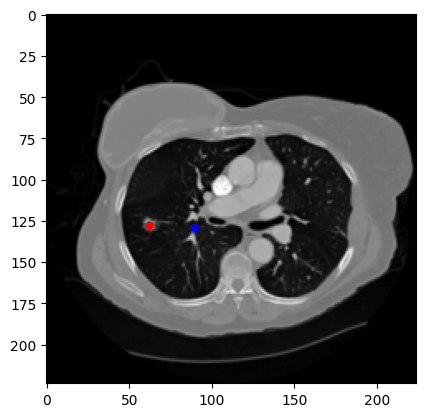

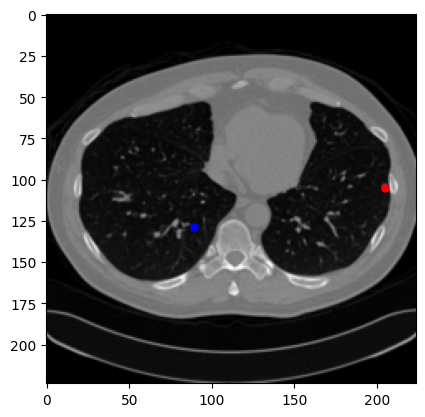

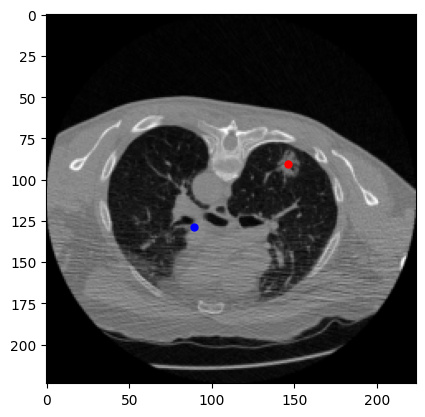

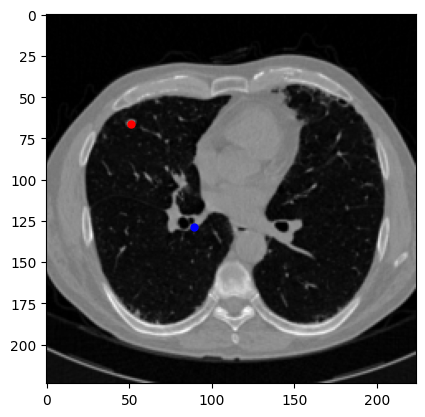

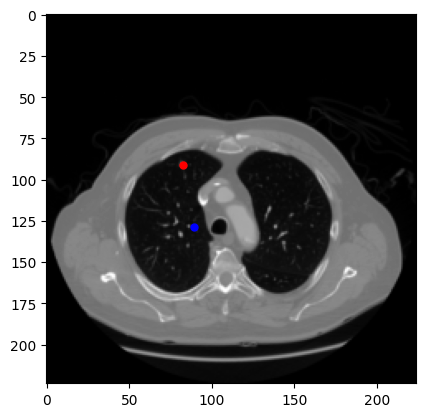

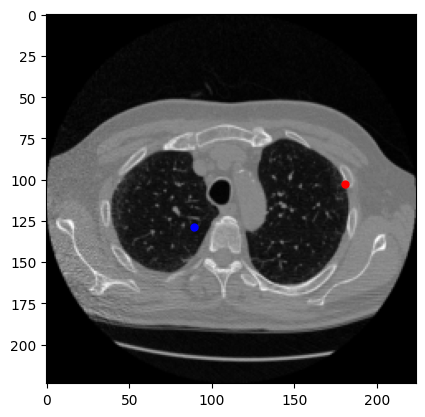

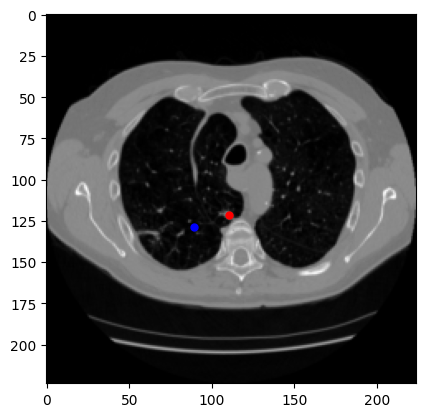

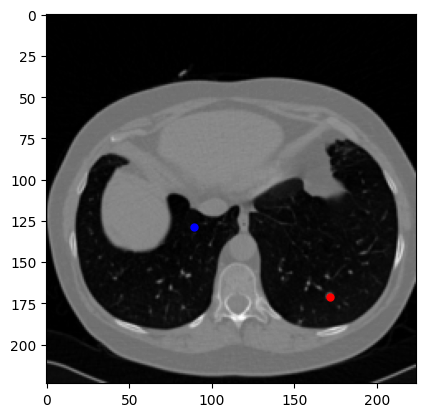

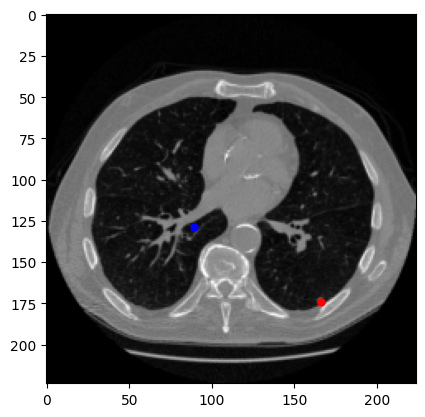

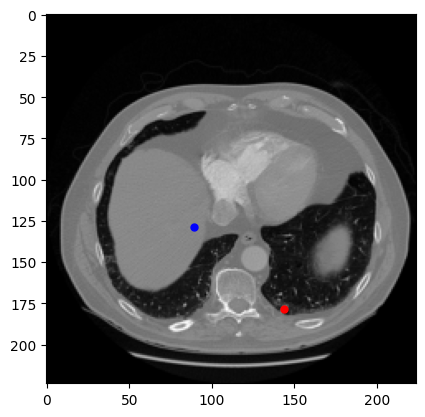

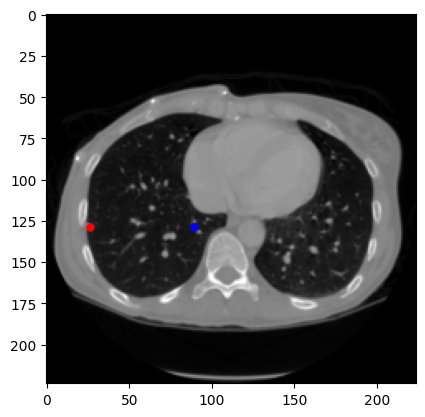

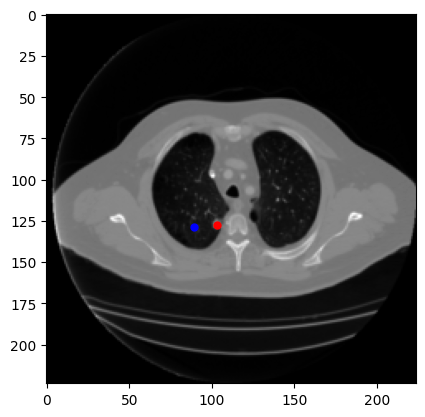

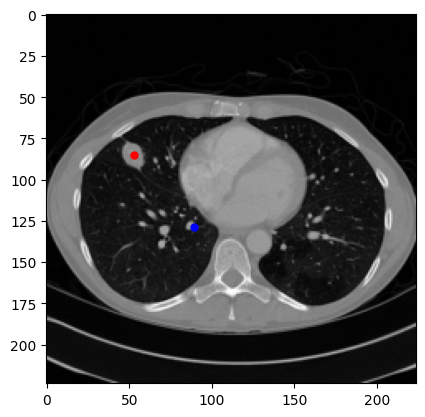

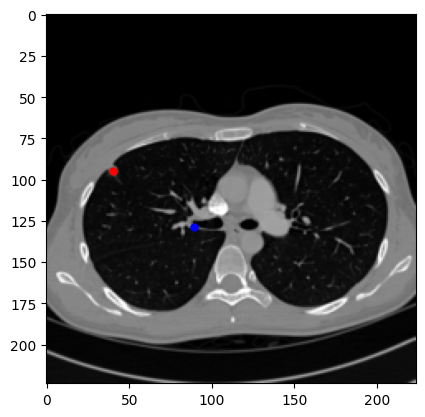

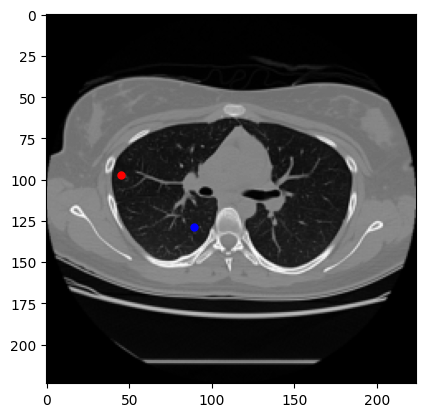

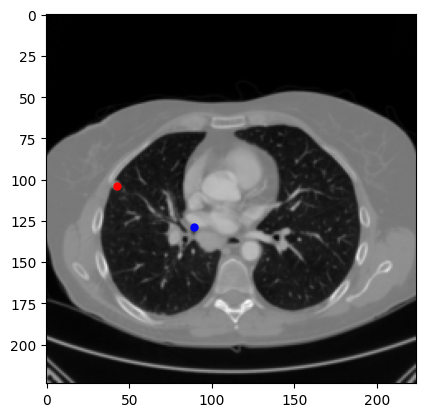

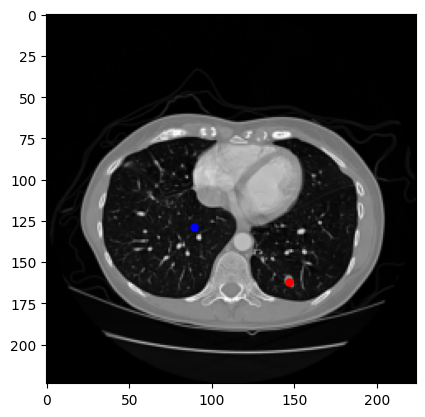

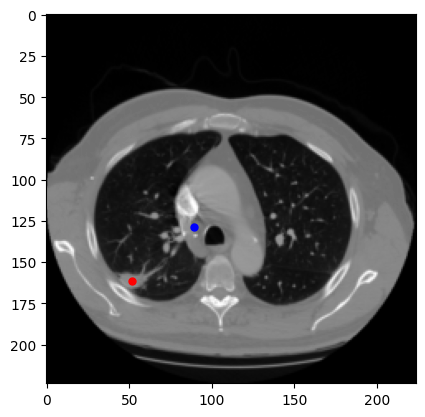

In [28]:
from sklearn.metrics import mean_squared_error

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(DEVICE), labels.float().to(DEVICE)
        images = images.unsqueeze(1) if images.ndim == 3 else images

        outputs = model(images)  # shape: (B, 2)
        
        plt.figure()
        plt.imshow(images[0].cpu().permute(1, 2, 0).mean(axis=-1) * 0.5 + 0.5, cmap='gray')
        x, y = outputs[0].cpu()
        a, b = labels[0].cpu()
        print(x, y, a, b)
        
        plt.plot(x, y, 'bo', markersize=5)
        plt.plot(a, b, 'ro', markersize=5)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(outputs.cpu().numpy())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# MSE
mse = mean_squared_error(y_true, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

# Euclidean distance per point
distances = np.linalg.norm((y_true - y_pred), axis=1)
mean_distance = distances.mean()
print(f"Mean Euclidean Distance: {mean_distance:.2f} pixels")